<a href="https://colab.research.google.com/github/Skander28/LastWork/blob/main/NewAraElectra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install pyarabic
!pip install optuna==2.3.0
!pip uninstall -y transformers accelerate
!pip install transformers accelerate
!pip install tokenizers==0.9.4


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.6/258.6 kB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 14.4 MB/s eta 0:00:00
  Created wheel for optuna: filename=optuna-2.3.0-py3-none-any.whl size=359702 sha256=ad48924992d0080654cbc9256681ee71c2d024bd734254885de1aeacc54a2dfc
  Stored i

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
# import pyarabic.araby as ar
import re, functools, operator, string
import optuna, gc, random, os  
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from transformers.data.processors import SingleSentenceClassificationProcessor
from transformers import Trainer , TrainingArguments
from transformers.trainer_utils import EvaluationStrategy
from transformers.data.processors.utils import InputFeatures
from sklearn.utils import resample
import logging

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

In [3]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.  

    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi
    
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Mon May 29 08:50:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

In [5]:

from google.colab import drive
drive.mount('/content/drive')
     
# Read the given dataset which contain the Ids and the labels
filtered_df = pd.read_csv('/content/drive/MyDrive/Thisone.csv',
                 lineterminator='\n')

filtered_df.head()

Mounted at /content/drive


,Unnamed: 0,id,text,dialect,word_count,char_count
0,0,1152861142416576384,طيب اعرفو رئيس وزرائكم الاول وتعالو حاسبو رياض...,DZ,9,57
1,1,921392744878264448,@khaireddineroub اوكي ماتنساش روراوة ثاني لازم...,DZ,16,94
2,2,960133615689576448,@safasafa2339 يا ختي ديجا كي نشوف سمو نبدا نرج...,DZ,12,54
3,3,1121522092581769216,اوو وش لي مش وخدين بلنا منو,DZ,7,30
4,4,1187345510874656768,@Hadjer12345678 تقولي راكي تهدري عليا 😂😂😂,DZ,6,41


In [6]:
# a class representing the dataset
class Dataset:
    def __init__(
        self,
        name,
        train,
        test,
        label_list,
    ):
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [7]:
class BERTModelDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(BERTModelDataset).__init__()
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map
  
    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())
    
      encoded_review = self.tokenizer.encode_plus(
      text,
      max_length= self.max_len,
      add_special_tokens= True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      truncation='longest_first',
      return_attention_mask=True,
      return_tensors='pt'
    )
      input_ids = encoded_review['input_ids'].to(device)
      attention_mask = encoded_review['attention_mask'].to(device)

      return InputFeatures(input_ids=input_ids.flatten(), attention_mask=attention_mask.flatten(), label=self.label_map[self.target[item]])

In [ ]:
# def data_cleaning (text):
#   try:
#     text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
#     text = re.sub(r'^http?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
#     text = re.sub(r"http\S+", "", text)
#     text = re.sub(r"https\S+", "", text)
#     text = re.sub(r'\s+', ' ', text)
#     text = re.sub("(\s\d+)","",text) 
#     text = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", "", text)
#     text = re.sub("\d+", " ", text)
#     text = ar.strip_tashkeel(text)
#     text = ar.strip_tatweel(text)
#     text = text.replace("#", " ");
#     text = text.replace("@", " ");
#     text = text.replace("_", " ");
#     translator = str.maketrans('', '', string.punctuation)
#     text = text.translate(translator)
#     text = text.replace("آ", "ا")
#     text = text.replace("إ", "ا")
#     text = text.replace("أ", "ا")
#     text = text.replace("ؤ", "و")
#     text = text.replace("ئ", "ي")
#   except:
#     return text
   
#   return text

In [ ]:
# # Cleaning Training Data 
# filtered_df['tweets'] = filtered_df['tweets'].apply(lambda x:   data_cleaning(x))

In [8]:
Extra_Len = 6 # an extra padding in length , found to be useful for increasing F-score
Max_Len = filtered_df["text"].str.split().str.len().max() + Extra_Len

print(Max_Len)

#Spliting the Training data
Test_Size = 0.05
Rand_Seed = 42 

# Split original data into train and test sets
train_set, test_set = train_test_split(filtered_df, test_size=Test_Size, random_state=Rand_Seed)

# Split training data into train and validation sets
train_set, evaluation_set = train_test_split(train_set, test_size=Test_Size, random_state=Rand_Seed)

print("Train set: ")
print(train_set["dialect"].value_counts())
print("---------------------------")
print ("Evaluation set: ")
print (evaluation_set["dialect"].value_counts())
print("---------------------------")
print ("test set: ")
print (test_set["dialect"].value_counts())

93
Train set: 
DZ    16283
TN    16260
LY    16251
MA    16210
Name: dialect, dtype: int64
---------------------------
Evaluation set: 
MA    866
TN    862
DZ    860
LY    834
Name: dialect, dtype: int64
---------------------------
test set: 
MA    931
LY    922
TN    885
DZ    864
Name: dialect, dtype: int64


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


Model_Used = "ZeyadAhmed/AraElectra-Arabic-SQuADv2-QA"
Task_Name = "classification"

def model_init():
  return AutoModelForSequenceClassification.from_pretrained(Model_Used, return_dict=True, num_labels=len(label_map))

def compute_metrics(p): #p should be of type EvalPrediction
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)
    print(classification_report(p.label_ids, preds))
    print(confusion_matrix(p.label_ids, preds))

    test_confusion_matrix = confusion_matrix(p.label_ids, preds, labels=[0, 1, 2, 3])
    sns.set(font_scale=1.2)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 16}, linewidths=0.5, linecolor='black', ax=ax)
    ax.set_xlabel('Predicted Label', fontsize=14)
    ax.set_ylabel('True Label', fontsize=14)
    ax.set_xticklabels(['LY', 'DZ', 'MA', 'TN'], fontsize=12)
    ax.set_yticklabels(['LY', 'DZ', 'MA', 'TN'], fontsize=12)
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()

    macro_f1_pos_neg = f1_score(p.label_ids, preds, average='macro', labels=[1, 2])
    macro_f1 = f1_score(p.label_ids, preds, average='macro')
    macro_precision = precision_score(p.label_ids, preds, average='macro')
    macro_recall = recall_score(p.label_ids, preds, average='macro')
    acc = accuracy_score(p.label_ids, preds)

    num_classes = len(np.unique(p.label_ids))

#     if num_classes == 2:
#         # Binary classification case
#         label_pos = np.where(np.unique(p.label_ids) == 1)[0][0]
#         probabilities = p.predictions[:, label_pos]  # Use the probability of the positive class
#         fpr, tpr, _ = roc_curve(p.label_ids, probabilities)
#         roc_auc = auc(fpr, tpr)

#         plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
#         plt.plot([0, 1], [0, 1], 'k--')
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.title('Receiver Operating Characteristic')
#         plt.legend(loc='lower right')
#         plt.show()

#         return {
#             'macro_f1': macro_f1,
#             'macro_f1_pos_neg': macro_f1_pos_neg,
#             'macro_precision': macro_precision,
#             'macro_recall': macro_recall,
#             'accuracy': acc,
#             'roc_auc': roc_auc,
#             'roc_curve': (fpr, tpr),
#         }
#     else:
        # Multiclass classification case
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for class_label in range(num_classes):
        probabilities = p.predictions[:, class_label]
        fpr[class_label], tpr[class_label], _ = roc_curve(
            p.label_ids, probabilities, pos_label=class_label
        )
        roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

    for class_label in range(num_classes):
        plt.plot(fpr[class_label], tpr[class_label],
                 label='ROC curve of class %d (area = %0.2f)' % (class_label, roc_auc[class_label]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
  
    return {
        'macro_f1': macro_f1,
        'macro_f1_pos_neg': macro_f1_pos_neg,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'accuracy': acc
  }

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [11]:
label_list = list(train_set["dialect"].unique())
#sentence_list = ['DZ', 'TN', 'MA', 'LY']
#ew_label_list = [sentence_list[label] for label in label_list]
print(label_list)
print(train_set["dialect"].value_counts())

data_set = Dataset( "OLY", train_set, evaluation_set, label_list )

# Define the list of class names
#label_list = ['DZ', 'TN', 'MA', 'LY']

# Create a label map that maps class names to their corresponding indices
label_map = {v: i for i, v in enumerate(label_list)}

# Print the label map
print(label_map)

train_dataset = BERTModelDataset(train_set["text"].to_list(),
                                 train_set["dialect"].to_list(),Model_Used,int(Max_Len),label_map)

evaluation_dataset = BERTModelDataset(evaluation_set["text"].to_list(),
                                      evaluation_set["dialect"].to_list(),Model_Used,int(Max_Len),label_map)

test_dataset = BERTModelDataset(test_set["text"].to_list(),
                                      test_set["dialect"].to_list(),Model_Used,int(Max_Len),label_map)

['LY', 'DZ', 'MA', 'TN']
DZ    16283
TN    16260
LY    16251
MA    16210
Name: dialect, dtype: int64
{'LY': 0, 'DZ': 1, 'MA': 2, 'TN': 3}


In [12]:
#define training arguments
training_args = TrainingArguments("./train")
training_args.lr_scheduler_type = 'cosine'
training_args.evaluate_during_training = True
training_args.adam_epsilon =1e-8 
training_args.learning_rate = 5e-05
training_args.fp16 = True
training_args.per_device_train_batch_size = 64
training_args.per_device_eval_batch_size = 32
training_args.gradient_accumulation_steps = 2
training_args.num_train_epochs= 4
training_args.warmup_steps = 0 
training_args.evaluation_strategy = EvaluationStrategy.EPOCH
training_args.seed = 42 
training_args.disable_tqdm = False

In [13]:
training_args.dataloader_pin_memory = False
gc.collect()
torch.cuda.empty_cache()
set_seed(Rand_Seed) 

trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset= evaluation_dataset,
    compute_metrics=compute_metrics
)



print(training_args.seed)

Some weights of the model checkpoint at ZeyadAhmed/AraElectra-Arabic-SQuADv2-QA were not used when initializing ElectraForSequenceClassification: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at ZeyadAhmed/AraElectra-Arabic-SQuADv2-QA and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model 

42


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch,Training Loss,Validation Loss,Macro F1,Macro F1 Pos Neg,Macro Precision,Macro Recall,Accuracy
1,0.917800,0.618497,0.762646,0.759404,0.770588,0.762917,0.763296
2,0.496400,0.494175,0.821889,0.815282,0.823792,0.821093,0.821157
3,0.289900,0.502925,0.837967,0.832602,0.840698,0.837210,0.837522
4,0.188800,0.529176,0.838780,0.835304,0.841182,0.838172,0.838399


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


              precision    recall  f1-score   support

           0       0.82      0.73      0.77       834
           1       0.79      0.67      0.72       860
           2       0.79      0.81      0.80       866
           3       0.69      0.85      0.76       862

    accuracy                           0.76      3422
   macro avg       0.77      0.76      0.76      3422
weighted avg       0.77      0.76      0.76      3422

[[609  56  40 129]
 [ 44 572 113 131]
 [ 36  56 701  73]
 [ 52  42  38 730]]


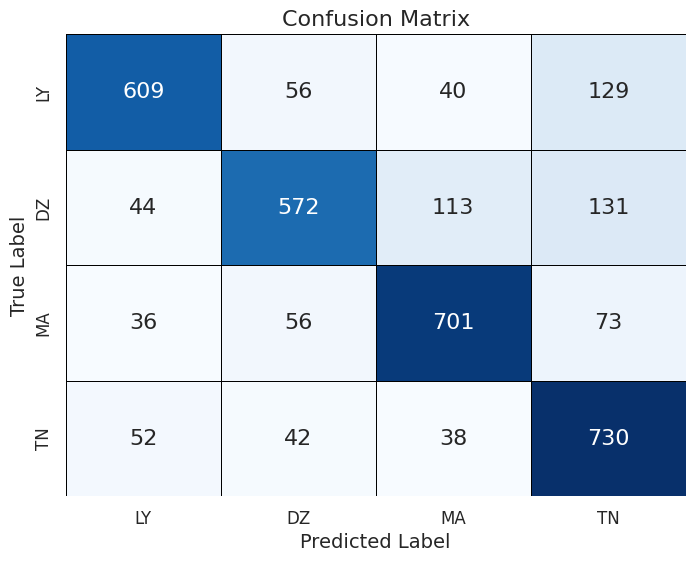

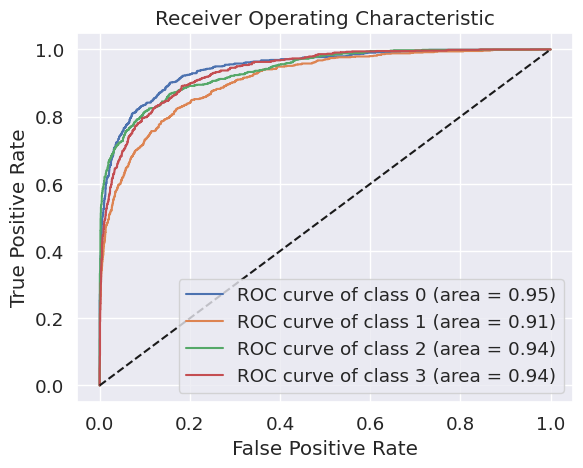

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

              precision    recall  f1-score   support

           0       0.86      0.82      0.84       834
           1       0.75      0.81      0.78       860
           2       0.87      0.83      0.85       866
           3       0.82      0.82      0.82       862

    accuracy                           0.82      3422
   macro avg       0.82      0.82      0.82      3422
weighted avg       0.82      0.82      0.82      3422

[[680  70  23  61]
 [ 38 699  60  63]
 [ 24  85 720  37]
 [ 49  76  26 711]]


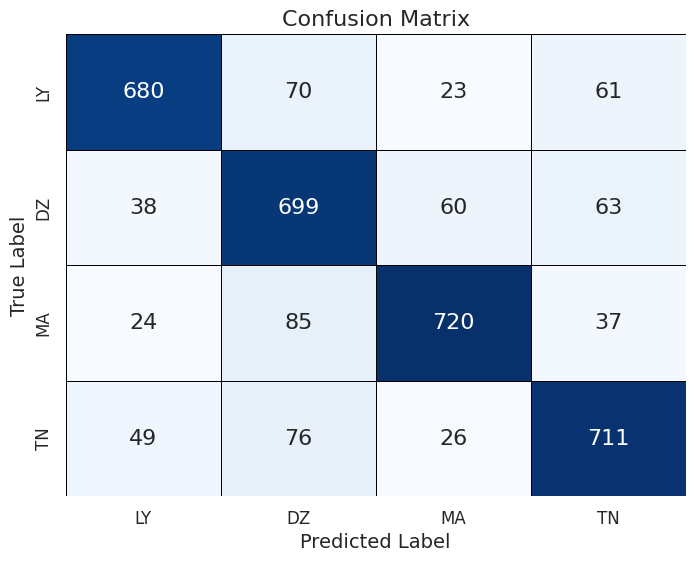

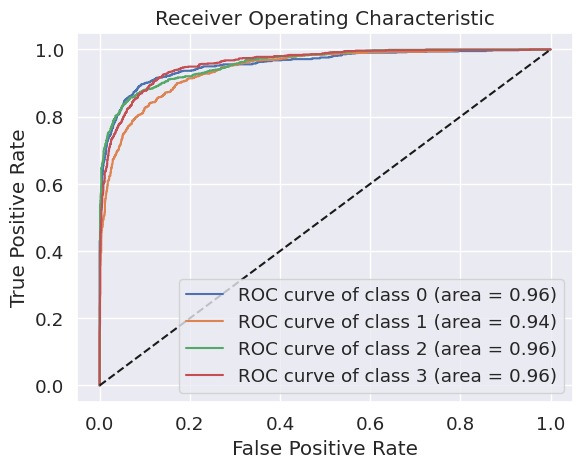

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

              precision    recall  f1-score   support

           0       0.89      0.80      0.84       834
           1       0.77      0.84      0.80       860
           2       0.86      0.87      0.86       866
           3       0.85      0.83      0.84       862

    accuracy                           0.84      3422
   macro avg       0.84      0.84      0.84      3422
weighted avg       0.84      0.84      0.84      3422

[[670  82  28  54]
 [ 33 724  56  47]
 [ 16  75 753  22]
 [ 37  63  43 719]]


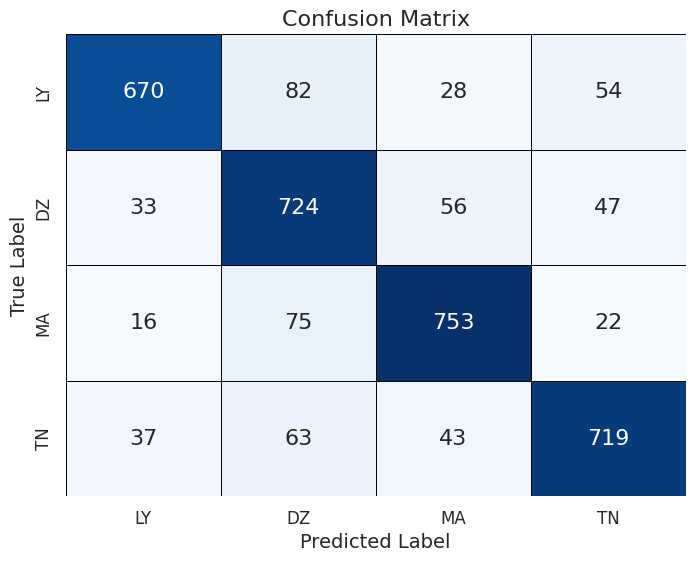

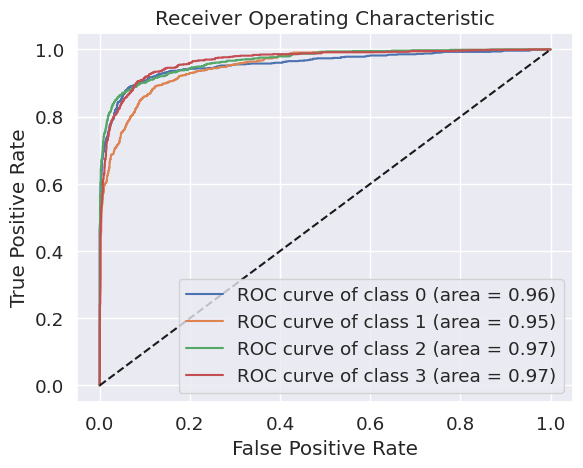

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       834
           1       0.77      0.85      0.81       860
           2       0.86      0.87      0.86       866
           3       0.87      0.82      0.84       862

    accuracy                           0.84      3422
   macro avg       0.84      0.84      0.84      3422
weighted avg       0.84      0.84      0.84      3422

[[679  81  26  48]
 [ 38 730  52  40]
 [ 22  74 753  17]
 [ 44  64  47 707]]


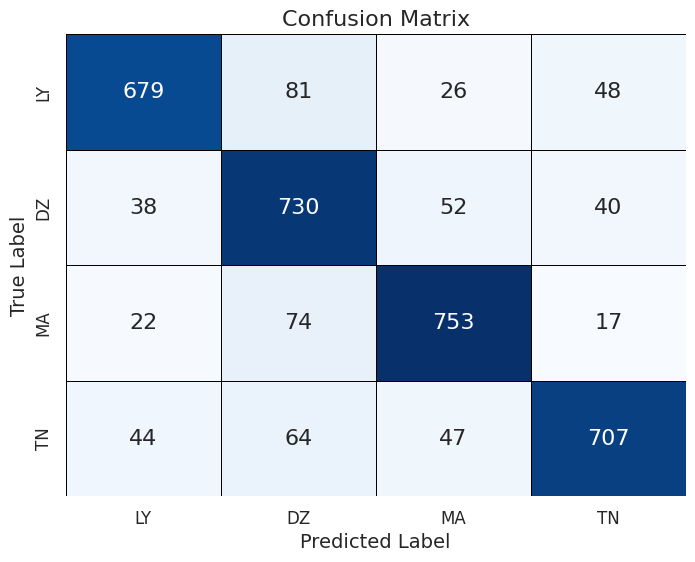

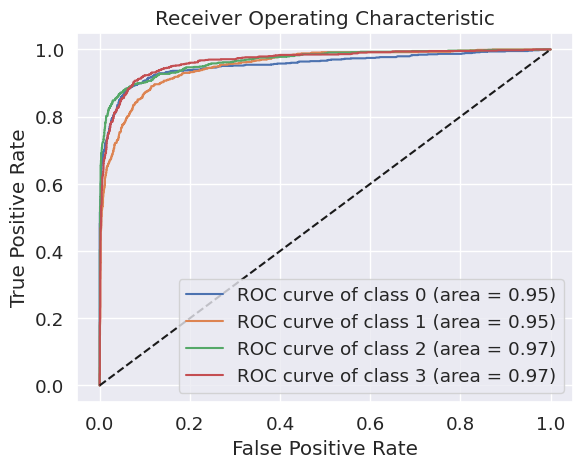

TrainOutput(global_step=2032, training_loss=0.46876308181154447, metrics={'train_runtime': 1451.7993, 'train_samples_per_second': 179.099, 'train_steps_per_second': 1.4, 'total_flos': 1.2426818513675904e+16, 'train_loss': 0.46876308181154447, 'epoch': 4.0})

In [14]:
import os
os.environ["WANDB_DISABLED"] = "true"
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


              precision    recall  f1-score   support

           0       0.89      0.81      0.85       922
           1       0.77      0.84      0.81       864
           2       0.85      0.88      0.87       931
           3       0.89      0.86      0.87       885

    accuracy                           0.85      3602
   macro avg       0.85      0.85      0.85      3602
weighted avg       0.85      0.85      0.85      3602

[[751  85  43  43]
 [ 41 727  64  32]
 [ 18  69 823  21]
 [ 33  59  35 758]]


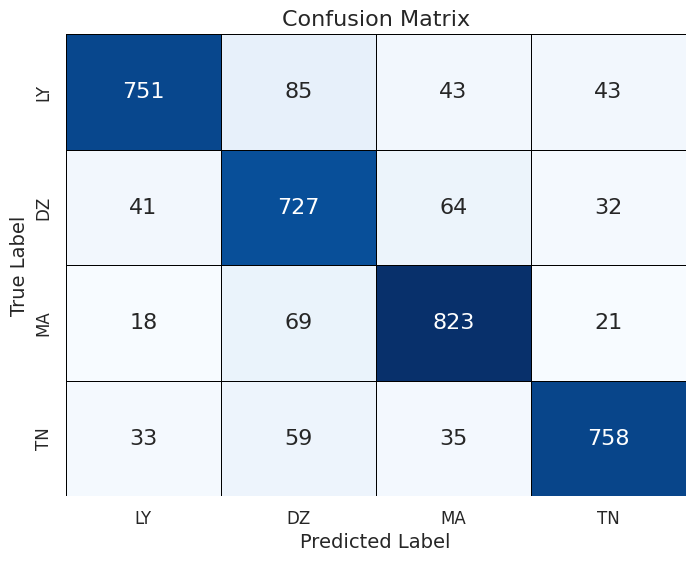

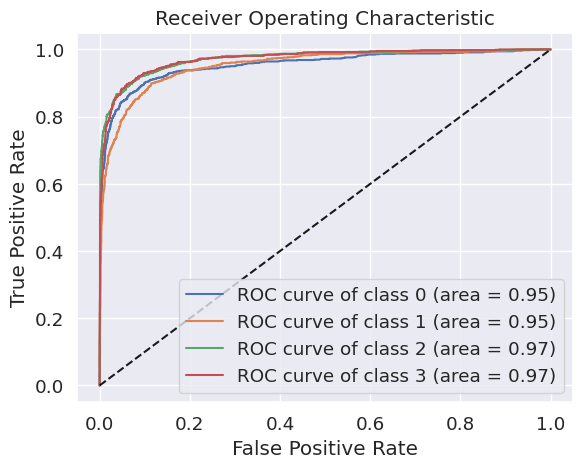

{'test_loss': 0.5148190855979919, 'test_macro_f1': 0.8492217599915803, 'test_macro_f1_pos_neg': 0.8370650780731053, 'test_macro_precision': 0.8511769432971843, 'test_macro_recall': 0.8491154216076642, 'test_accuracy': 0.8492504164353137, 'test_runtime': 7.5945, 'test_samples_per_second': 474.291, 'test_steps_per_second': 14.879}


In [15]:
# Evaluate test set
test_results = trainer.predict(test_dataset)

# Print test set results
print(test_results.metrics)

In [16]:
# # Save the trained model to a file
# torch.save(trainer.model.state_dict(), "trainer.pth")

In [17]:
# import torch
# from transformers import AutoTokenizer, ElectraForSequenceClassification

# model = ElectraForSequenceClassification.from_pretrained(Model_Used, num_labels=4).to(device)

# # Load the trained model from disk
# model_state_dict = torch.load('/content/trainer.pth')
# model.load_state_dict(model_state_dict)

# # Load the tokenizer
# tokenizer = AutoTokenizer.from_pretrained(Model_Used)



# # Tokenize the input sentence
# input_sentence = "نبي نروح للحوش "
# #input_sentence  = "شوكران علا هاد "
# #input_sentence  = "فرحان و نتشرف الي انا من اقلية الشعب الي عمري ما صدقت كذبة الثورة و الديمقراطية و ما عداها عليا حتى سياسي ملي حكمو من 2011 و ما تحكموش في تفكيري باجات فيسبوك و اعلاميين مرتزقة و سبر اراء غالط"
# tokenized_input = tokenizer(input_sentence, padding=True, truncation=True, max_length=Max_Len, return_tensors='pt')
# input_ids = tokenized_input['input_ids'].to(device)
# attention_mask = tokenized_input['attention_mask'].to(device)

# # Pass the input tensor through the model to obtain the predictions
# outputs = model(input_ids=input_ids, attention_mask=attention_mask)
# predicted_labels = torch.argmax(outputs.logits, dim=1)
# confidence_score = torch.softmax(outputs.logits, dim=1)[0][predicted_labels]

# # Print the predicted class and its corresponding label
# #{'MA': 0, 'DZ': 1, 'TN': 2, 'LY': 3}

# label_map = {0: "MA", 1: "DZ", 2: "TN", 3: "LY"}
# predicted_class = label_map[predicted_labels.item()]
# print("Predicted class:", predicted_class)
# print("Confidence score:", confidence_score.item())
